In [ ]:
#This notebook uses the metadatadatadata.csv file and the classification is: 0 for food, 1 for isolation, 2 for brushing. 
# val_dl.pkl
# myModel.pkl

In [1]:
import pickle
from pathlib import Path

In [2]:
# Import necessary libraries
from pathlib import Path
import pandas as pd

# Define the path to your data
data_path = Path('../../data/raw_data/zenodo.4008297')

# Read your metadata file
metadata_file = data_path / 'metadatadatadata.csv'
df = pd.read_csv(metadata_file)

# Display the first few rows of the DataFrame
print(df.head())

# 'filename' is our file name column, then we can construct the relative path like this
df['relative_path'] = '/' + df['filename'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID']]

# Display the first few rows of the modified DataFrame
print(df.head())
#


   Unnamed: 0                     filename  situation  sex  \
0           0  F_MAG01_EU_FN_FED01_106.wav       food    0   
1           1  I_NUL01_MC_MI_SIM01_304.wav  isolation    1   
2           2  I_MEG01_MC_FI_SIM01_304.wav  isolation    0   
3           3  B_CAN01_EU_FN_GIA01_205.wav   brushing    0   
4           4  F_MAG01_EU_FN_FED01_304.wav       food    0   

                breed  classID  
0  european_shorthair        0  
1          maine_coon        1  
2          maine_coon        1  
3  european_shorthair        2  
4  european_shorthair        0  
                  relative_path  classID
0  /F_MAG01_EU_FN_FED01_106.wav        0
1  /I_NUL01_MC_MI_SIM01_304.wav        1
2  /I_MEG01_MC_FI_SIM01_304.wav        1
3  /B_CAN01_EU_FN_GIA01_205.wav        2
4  /F_MAG01_EU_FN_FED01_304.wav        0


In [3]:
# using the PyTorch and Torchaudio libraries
import math
import random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from pathlib import Path  # Import Path from pathlib
import pandas as pd
import os  # Import os module

# Define the AudioUtil class for loading audio files
class AudioUtil:
    
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return sig, sr
#-----------------------------------------------------------
    # CONVERTING MONO FILES TO STEREO
#-----------------------------------------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return (resig, sr)
#----------------------------------------------------------------------
    # STANDARIZING SAMPLES RATES
#-----------------------------------------------------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
       
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
#----------------------------------------------------------------------------------
    # RESIZE TO THE SAME LENGTH
#----------------------------------------------------------------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr // 1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:, :max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
      
        return (sig, sr)
#----------------------------------------------------------------------------------------------
    # DATA AUGMENTATION
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
#-----------------------------------------------------------------------------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

# -----------------------------------------------------------------------------------------
    # Generate a Spectrogram
# ------------------------------------------------------------------------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo, etc.
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec

    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec



In [4]:
#-------------------------------------------------------------------------------------------
#Define Custom Data Loader
#-------------------------------------------------------------------------------------------
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ------------------------------------------------------------------------------------------
# Sound Dataset
# ------------------------------------------------------------------------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
# -------------------------------------------------------------------------------------------
  # Number of items in dataset
# --------------------------------------------------------------------------------------------
  def __len__(self):
    return len(self.df)    
    
# ---------------------------------------------------------------------------------------------
  # Get i'th item in dataset
# ---------------------------------------------------------------------------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [5]:
#-------------------------------------------------------------------------------------------
#Prepare Batches of Data with the Data Loader
#-------------------------------------------------------------------------------------------
from torch.utils.data import random_split

myds = SoundDS(df, data_path)
#-------------------------------------------------------------------------------------------
# Random split of 80:20 between training and validation
#-------------------------------------------------------------------------------------------
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
#-------------------------------------------------------------------------------------------
# Create training and validation data loaders
#-------------------------------------------------------------------------------------------
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


In [6]:
# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------
# CREATE MODEL 
# -------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------
import torch.nn as nn  
import torch.nn.functional as F
from torch.nn import init


# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self, num_channels=2):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(num_channels, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=3)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

Epoch: 0, Loss: 1.16, Accuracy: 0.20
Epoch: 1, Loss: 1.07, Accuracy: 0.44
Epoch: 2, Loss: 1.01, Accuracy: 0.56
Epoch: 3, Loss: 0.99, Accuracy: 0.53
Epoch: 4, Loss: 0.97, Accuracy: 0.55
Epoch: 5, Loss: 0.97, Accuracy: 0.55
Epoch: 6, Loss: 0.97, Accuracy: 0.55
Epoch: 7, Loss: 0.94, Accuracy: 0.54
Epoch: 8, Loss: 0.95, Accuracy: 0.56
Epoch: 9, Loss: 0.94, Accuracy: 0.55
Epoch: 10, Loss: 0.94, Accuracy: 0.57
Epoch: 11, Loss: 0.93, Accuracy: 0.57
Epoch: 12, Loss: 0.93, Accuracy: 0.57
Epoch: 13, Loss: 0.91, Accuracy: 0.58
Epoch: 14, Loss: 0.88, Accuracy: 0.58
Epoch: 15, Loss: 0.90, Accuracy: 0.60
Epoch: 16, Loss: 0.87, Accuracy: 0.63
Epoch: 17, Loss: 0.89, Accuracy: 0.59
Epoch: 18, Loss: 0.89, Accuracy: 0.58
Epoch: 19, Loss: 0.88, Accuracy: 0.65
Epoch: 20, Loss: 0.86, Accuracy: 0.62
Epoch: 21, Loss: 0.85, Accuracy: 0.61
Epoch: 22, Loss: 0.86, Accuracy: 0.59
Epoch: 23, Loss: 0.84, Accuracy: 0.60
Epoch: 24, Loss: 0.84, Accuracy: 0.62
Epoch: 25, Loss: 0.84, Accuracy: 0.61
Epoch: 26, Loss: 0.86,

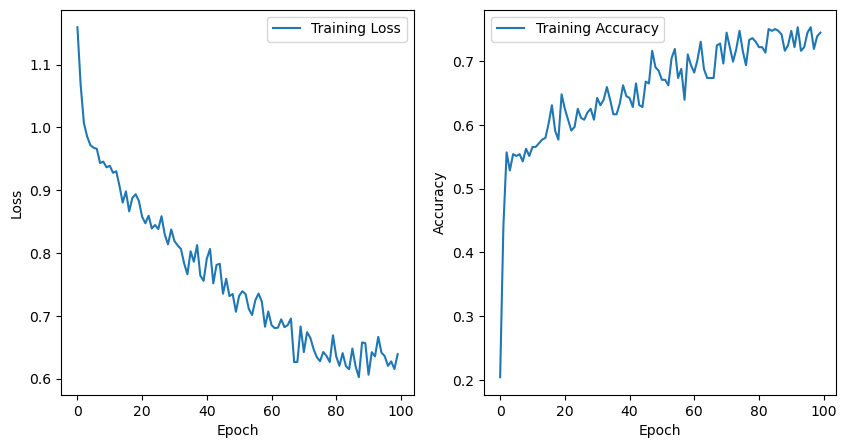

In [7]:
#-------------------------------------------------------------------------------------------
#TRAINING2
#-------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# ...

def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')

    # Lists to store the Loss and Accuracy for each epoch
    losses = []
    accuracies = []

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

        # Save Loss and Accuracy for plotting
        losses.append(avg_loss)
        accuracies.append(acc)

    print('Finished Training')

    # Plot Loss and Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# ...

num_epochs = 100
training(myModel, train_dl, num_epochs)

In [8]:
# ---------------------------------------------------------------------
# Inference
# ---------------------------------------------------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.64, Total items: 88


In [17]:
# Save the model using pickle
model_save_path = Path('../../data/trained_models/my_model.pkl')
with open(model_save_path, 'wb') as model_file:
    pickle.dump(myModel, model_file)

# Save the training and validation data loaders
train_dl_save_path = Path('../../data/processed_data/train_data_loader.pkl')
val_dl_save_path = Path('../../data/processed_data/val_data_loader.pkl')
with open(train_dl_save_path, 'wb') as train_dl_file, open(val_dl_save_path, 'wb') as val_dl_file:
    pickle.dump(train_dl, train_dl_file)
    pickle.dump(val_dl, val_dl_file)

# Save the dataset
dataset_save_path = Path('../../data/processed_data/my_dataset.pkl')
with open(dataset_save_path, 'wb') as dataset_file:
    pickle.dump(myds, dataset_file)

In [13]:
#TESTING IF IT WORKS
def predict_class(model, data_loader, audio_file, sr, channel, duration, shift_pct):
    # Put the model in evaluation mode
    model.eval()

    # Open the audio file and convert it to a spectrogram
    aud = AudioUtil.open(audio_file)
    reaud = AudioUtil.resample(aud, sr)
    rechan = AudioUtil.rechannel(reaud, channel)
    dur_aud = AudioUtil.pad_trunc(rechan, duration)
    shift_aud = AudioUtil.time_shift(dur_aud, shift_pct)
    spectrogram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_spectrogram = AudioUtil.spectro_augment(spectrogram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    # Ensure the spectrogram has two channels
    if aug_spectrogram.shape[0] == 1:
        aug_spectrogram = np.concatenate([aug_spectrogram, aug_spectrogram], axis=0)

    # Convert the input to a PyTorch tensor and move it to the appropriate device
    spectrogram = torch.tensor(aug_spectrogram)  # Assuming spectrogram is a NumPy array
    spectrogram = spectrogram.unsqueeze(0)  # Add a batch dimension
    spectrogram = spectrogram.to(device)  # Move to GPU if available

    # Forward pass through the model
    with torch.no_grad():
        output = model(spectrogram)

    # Get the predicted class index
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()  # Return the predicted class as an integer

# Example usage with val_dl
sample_audio_file = '../../data/raw_data/zenodo.4008297/F_MAG01_EU_FN_FED01_106.wav'
predicted_class = predict_class(myModel, val_dl, sample_audio_file, 44100, 2, 4000, 0.4)

# Map the predicted class index to the actual class label (you need to have this mapping)
class_mapping = {0: 'hungry', 1: 'isolated', 2: 'brushing'}  
predicted_class_label = class_mapping[predicted_class]

print(f'This audio belongs to the class: {predicted_class_label}')


This audio belongs to the class: brushing


/var/folders/8h/nh4mtdpx06q89d24syrkkv7w0000gn/T/ipykernel_2832/3821493299.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(aug_spectrogram)  # Assuming spectrogram is a NumPy array
